In [1]:
pip install svgwrite cairosvg scikit-learn scipy numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import svgwrite
import cairosvg
from sklearn.linear_model import LinearRegression
from scipy.spatial import distance
from scipy.optimize import minimize

# Read CSV Files
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []

    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)

    return path_XYs

# Visualize Polylines
def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['r', 'g', 'b', 'c', 'm', 'y', 'k']  # Add more colors if needed

    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)

    ax.set_aspect('equal')
    plt.show()

# Detect Regular Shapes
def detect_straight_lines(XYs):
    for XY in XYs:
        if len(XY) < 2:
            continue
        reg = LinearRegression().fit(XY[:, 0].reshape(-1, 1), XY[:, 1])
        if np.allclose(reg.predict(XY[:, 0].reshape(-1, 1)), XY[:, 1], atol=1e-2):
            print("Detected straight line.")

# def detect_circles_ellipses(XYs):
#     for XY in XYs:
#         if len(XY) < 5:
#             continue
#         x0, y0 = np.mean(XY[:, 0]), np.mean(XY[:, 1])
#         distances = np.sqrt((XY[:, 0] - x0) ** 2 + (XY[:, 1] - y0) ** 2)
#         if np.allclose(distances, distances[0], atol=1e-2):
#             print("Detected circle.")
#         else:
#             # Fit an ellipse
#             def ellipse(params):
#                 x0, y0, a, b, angle = params
#                 theta = np.arctan2(XY[:, 1] - y0, XY[:, 0] - x0)
#                 return (XY[:, 0] - (x0 + a * np.cos(theta) * np.cos(angle) - b * np.sin(theta) * np.sin(angle))) ** 2 + \
#                        (XY[:, 1] - (y0 + a * np.cos(theta) * np.sin(angle) + b * np.sin(theta) * np.cos(angle))) ** 2

#             res = minimize(ellipse, [x0, y0, np.std(XY[:, 0]), np.std(XY[:, 1]), 0])
#             if res.success:
#                 print("Detected ellipse.")

def detect_circles_ellipses(XYs):
    for XY in XYs:
        if len(XY) < 5:
            continue
        x0, y0 = np.mean(XY[:, 0]), np.mean(XY[:, 1])
        distances = np.sqrt((XY[:, 0] - x0) ** 2 + (XY[:, 1] - y0) ** 2)
        if np.allclose(distances, distances[0], atol=1e-2):
            print("Detected circle.")
        else:
            # Fit an ellipse
            def ellipse(params):
                x0, y0, a, b, angle = params
                theta = np.arctan2(XY[:, 1] - y0, XY[:, 0] - x0)
                distances = (XY[:, 0] - (x0 + a * np.cos(theta) * np.cos(angle) - b * np.sin(theta) * np.sin(angle))) ** 2 + \
                       (XY[:, 1] - (y0 + a * np.cos(theta) * np.sin(angle) + b * np.sin(theta) * np.cos(angle))) ** 2
                return np.sum(distances) # Return the sum of squared distances as a single scalar value

            res = minimize(ellipse, [x0, y0, np.std(XY[:, 0]), np.std(XY[:, 1]), 0])
            if res.success:
                print("Detected ellipse.")

def detect_rectangles_rounded_rectangles(XYs):
    for XY in XYs:
        if len(XY) < 4:
            continue
        if XY.ndim != 2:
            print(f"Skipping invalid array with shape {XY.shape}")
            continue
        print(f"Processing array with shape {XY.shape}")
        dists = distance.pdist(XY, 'euclidean')
        if np.allclose(dists, np.mean(dists), atol=1e-2):
            print("Detected rectangle or rounded rectangle.")

def detect_regular_polygons(XYs):
    for XY in XYs:
        if len(XY) < 5:
            continue
        if XY.ndim != 2:
            print(f"Skipping invalid array with shape {XY.shape}")
            continue
        print(f"Processing array with shape {XY.shape}")
        dists = distance.pdist(XY, 'euclidean')
        if np.allclose(dists, np.mean(dists), atol=1e-2):
            print("Detected regular polygon.")

def detect_star_shapes(XYs):
    for XY in XYs:
        if len(XY) < 10:
            continue
        if XY.ndim != 2:
            print(f"Skipping invalid array with shape {XY.shape}")
            continue
        print(f"Processing array with shape {XY.shape}")
        dists = distance.pdist(XY, 'euclidean')
        if np.var(dists) > 0.1:
            print("Detected star shape.")

# Detect Symmetry
def detect_symmetry(XYs):
    for XY in XYs:
        if XY.ndim != 2:
            print(f"Skipping invalid array with shape {XY.shape}")
            continue
        centroid = np.mean(XY, axis=0)
        dists = distance.cdist(XY, XY, 'euclidean')
        sym_points = []
        for i in range(len(XY)):
            for j in range(i + 1, len(XY)):
                if np.allclose(dists[i, j], np.mean(dists)):
                    sym_points.append((i, j))
        if sym_points:
            print("Detected symmetry.")

# Complete Curves
def complete_curves(XYs):
    for XY in XYs:
        if len(XY) < 3:
            continue
        if XY.ndim != 2:
            print(f"Skipping invalid array with shape {XY.shape}")
            continue
        print(f"Processing array with shape {XY.shape}")
        distances = np.sqrt(np.sum(np.diff(XY, axis=0) ** 2, axis=1))
        mean_dist = np.mean(distances)
        for i in range(len(XY) - 1):
            if distances[i] > 2 * mean_dist:
                print("Completing curve between points", XY[i], "and", XY[i + 1])

# Convert Polylines to SVG and Rasterize
def polylines2svg(paths_XYs, svg_path):
    W, H = 0, 0
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W, H = max(W, np.max(XY[:, 0])), max(H, np.max(XY[:, 1]))

    padding = 0.1
    W, H = int(W + padding * W), int(H + padding * H)

    dwg = svgwrite.Drawing(svg_path, profile='tiny', shape_rendering='crispEdges')
    group = dwg.g()
    colours = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black']  # Use color names instead of single letters

    for i, path in enumerate(paths_XYs):
        path_data = []
        c = colours[i % len(colours)]
        for XY in path:
            path_data.append(("M", (XY[0, 0], XY[0, 1])))
            for j in range(1, len(XY)):
                path_data.append(("L", (XY[j, 0], XY[j, 1])))
            if not np.allclose(XY[0], XY[-1]):
                path_data.append(("Z", None))
        group.add(dwg.path(d=path_data, fill=c, stroke='none', stroke_width=2))

    dwg.add(group)
    dwg.save()

    png_path = svg_path.replace('.svg', '.png')
    fact = max(1, 1024 // min(H, W))

    cairosvg.svg2png(url=svg_path, write_to=png_path, parent_width=W, parent_height=H, output_width=fact*W, output_height=fact*H, background_color='white')
    return


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


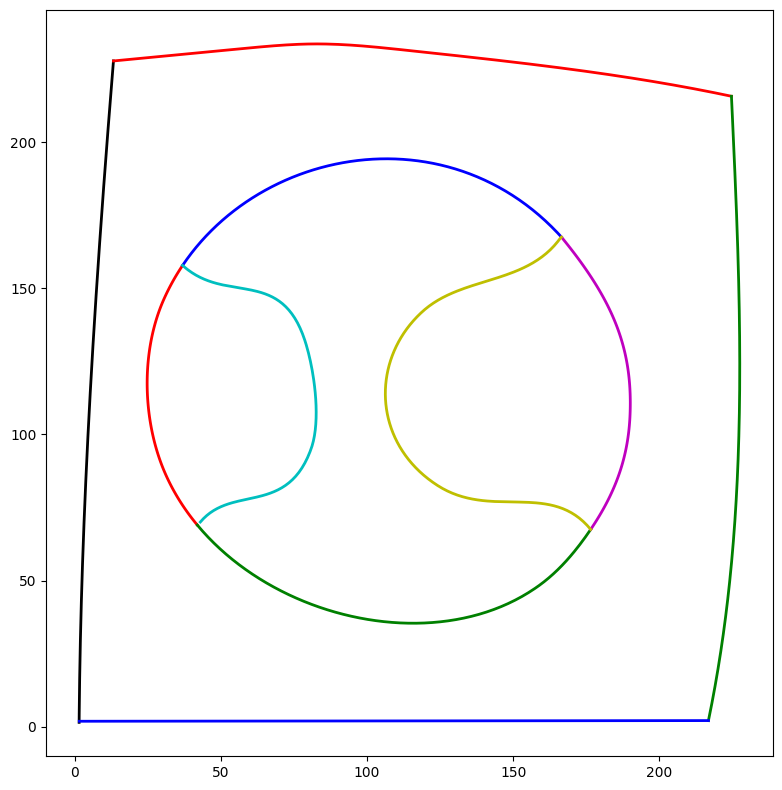

Processing array with shape (94, 2)
Processing array with shape (94, 2)
Processing array with shape (94, 2)
Detected star shape.
Processing array with shape (166, 2)
Processing array with shape (166, 2)
Processing array with shape (166, 2)
Detected star shape.
Processing array with shape (171, 2)
Processing array with shape (171, 2)
Processing array with shape (171, 2)
Detected star shape.
Processing array with shape (166, 2)
Processing array with shape (166, 2)
Processing array with shape (166, 2)
Detected star shape.
Processing array with shape (109, 2)
Processing array with shape (109, 2)
Processing array with shape (109, 2)
Detected star shape.
Processing array with shape (205, 2)
Processing array with shape (205, 2)
Processing array with shape (205, 2)
Detected star shape.
Processing array with shape (226, 2)
Processing array with shape (226, 2)
Processing array with shape (226, 2)
Detected star shape.
Processing array with shape (208, 2)
Processing array with shape (208, 2)
Proce

In [5]:
def main():
    # Load the CSV file
    # csv_path = 'path/to/your/csvfile.csv'
    paths_XYs = read_csv("frag0.csv")

    # Visualize the shapes
    plot(paths_XYs)

    # Apply shape detection
    for XYs in paths_XYs:
        detect_straight_lines(XYs)
        detect_circles_ellipses(XYs)
        detect_rectangles_rounded_rectangles(XYs)
        detect_regular_polygons(XYs)
        detect_star_shapes(XYs)

    # Detect symmetry
    for XYs in paths_XYs:
        detect_symmetry(XYs)

    # Complete curves
    for XYs in paths_XYs:
        complete_curves(XYs)

    # Convert to SVG and rasterize
    svg_path = '/content/drive/My Drive/Adobe/output.svg'
    polylines2svg(paths_XYs, svg_path)

if __name__ == "__main__":
    main()
